# Welcome to Full Stack Machine Learning's Week 3 Project!

Welcome to the taxi fare prediction project! In this project, you will be taking on the role of a Data Scientist tasked with developing a model that can predict the fare for a taxi ride in New York City. The [dataset](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) we will be using contains records of trips made by yellow and green taxis, as well as records of For-Hire Vehicle (FHV) trips.

As a Data Scientist, your goal will be to use this data to build an accurate model that can predict taxi fares. You will learn how to preprocess the data and train a model. Additionally, you will be introduced to event-driven Machine Learning pipelines and learn how to trigger these pipelines in the cloud using Metaflow.

By the end of this project, you will have gained valuable experience in building and evaluating Machine Learning models for real-world applications, as well as a deeper understanding of how to run pipelines in the cloud.

## Task 0: Install new Metaflow version to use event-triggering features

Run the next cell to update to the latest Metaflow release with event-triggering support. Note you only need to run it one time in the `full-stack-metaflow-corise` environment in your sandbox.

In [2]:
%%capture
! pip install -U metaflow


In [18]:
! conda install -c plotly plotly

Retrieving notices: ...working... done
Solving environment: done

## Package Plan ##

  environment location: /home/workspace/mambaforge/envs/full-stack-metaflow-corise

  added / updated specs:
    - plotly


The following NEW packages will be INSTALLED:

  plotly             plotly/noarch::plotly-5.14.1-py_0 
  tenacity           conda-forge/noarch::tenacity-8.2.2-pyhd8ed1ab_0 

The following packages will be UPDATED:

  ca-certificates                      2022.12.7-ha878542_0 --> 2023.5.7-hbcca054_0 
  certifi                            2022.12.7-pyhd8ed1ab_0 --> 2023.5.7-pyhd8ed1ab_0 


Proceed ([y]/n)? 

## Task 1: EDA

You can find the [original `.parquet` file here](https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet).

Suggestion: This week is primarily about task 2-3, and 4 if you have time. Don't spend more than an hour on Task 1.

In [ ]:
# imports
from metaflow import S3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# configuration
YELLOW = '#FFBC00'
GREEN = '#37795D'
PURPLE = '#5460C0'
BACKGROUND = '#F4EBE6'
colors = [GREEN, PURPLE]
custom_params = {
    'axes.spines.right': False, 'axes.spines.top': False,
    'axes.facecolor':BACKGROUND, 'figure.facecolor': BACKGROUND, 
    'figure.figsize':(8, 8)
}
sns_palette = sns.color_palette(colors, len(colors))
sns.set_theme(style='ticks', rc=custom_params)

ModuleNotFoundError: No module named 'plotly'

In [5]:
# Open a context manager to download data from the cloud.
s3 = S3(s3root='s3://outerbounds-datasets/taxi')

# Use Metaflow S3 client to get the latest file.
# This file is being updated every hour, simulating the changing, drifting, and sometimes broken nature of production data streams.
obj = s3.get('latest.parquet')
# The goal is to write a flow that builds and cross-validates a model to predicts the total fare of each taxi rid (row) in the dataset.
# Since the data is changing, Task 2 and 3 asks you to deploy a flow to production via Argo workflows, so your workflow can run automatically when this file changes in S3.

# Load the contents of the parquet file in memory.
df = pd.read_parquet(obj.path)

s3.close()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456641 entries, 0 to 3007098
Data columns (total 20 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   VendorID               456641 non-null  int64         
 1   tpep_pickup_datetime   456641 non-null  datetime64[ns]
 2   tpep_dropoff_datetime  456641 non-null  datetime64[ns]
 3   passenger_count        444597 non-null  float64       
 4   trip_distance          453125 non-null  float64       
 5   RatecodeID             444597 non-null  float64       
 6   store_and_fwd_flag     444597 non-null  object        
 7   PULocationID           456641 non-null  int64         
 8   DOLocationID           456641 non-null  int64         
 9   payment_type           456641 non-null  int64         
 10  fare_amount            456641 non-null  float64       
 11  extra                  456641 non-null  float64       
 12  mta_tax                456641 non-null  flo

In [7]:
df.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour
0,2,2023-05-10 08:32:10,2023-05-10 08:40:36,1.0,0.97,1.0,N,161,141,2,9.3,1.00,0.5,0.00,0.0,1.0,14.30,2.5,0.00,0
1,2,2023-05-10 08:55:08,2023-05-10 09:01:27,1.0,1.10,1.0,N,43,237,1,7.9,1.00,0.5,4.00,0.0,1.0,16.90,2.5,0.00,1
2,2,2023-05-10 08:25:04,2023-05-10 08:37:49,1.0,2.51,1.0,N,48,238,1,14.9,1.00,0.5,15.00,0.0,1.0,34.90,2.5,0.00,0
3,1,2023-05-10 08:03:48,2023-05-10 08:13:25,0.0,1.90,1.0,N,138,7,1,12.1,7.25,0.5,0.00,0.0,1.0,20.85,0.0,1.25,0
4,2,2023-05-10 08:10:29,2023-05-10 08:21:19,1.0,1.43,1.0,N,107,79,1,11.4,1.00,0.5,3.28,0.0,1.0,19.68,2.5,0.00,0


In [10]:
df.trip_distance.isnull().values.any()

True

In [12]:
obviously_bad_data_filters = [

    df.fare_amount > 0,         # fare_amount in US Dollars
    df.trip_distance <= 100,    # trip_distance in miles
    df.trip_distance > 0,

    # done: add some logic to filter out what you decide is bad data!
    # TIP: Don't spend too much time on this step for this project though, it practice it is a never-ending process.
    df.passenger_count > 0,
    ~df.trip_distance.isnull()
]

for f in obviously_bad_data_filters:
    df = df[f]

/tmp/ipykernel_24228/3801369416.py:14: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[f]


In [13]:
df.describe()

,VendorID,passenger_count,trip_distance,RatecodeID,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee,hour
count,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000,423813.000000
mean,1.746718,1.436218,3.879158,1.533650,165.376100,163.164919,1.239150,20.047428,1.561016,0.496736,3.416237,0.645119,0.998016,28.975142,2.270300,0.143303,71.421773
std,0.434891,0.930005,4.941971,6.678562,63.746841,70.544870,0.475748,18.847110,1.839024,0.091222,4.069495,2.212374,0.037393,23.397335,0.722143,0.398238,37.521532
min,1.000000,1.000000,0.010000,1.000000,1.000000,1.000000,1.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.000000,1.010000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.120000,1.000000,132.000000,113.000000,1.000000,9.300000,0.000000,0.500000,0.000000,0.000000,1.000000,15.470000,2.500000,0.000000,41.000000
50%,2.000000,1.000000,1.900000,1.000000,161.000000,162.000000,1.000000,12.800000,1.000000,0.500000,2.660000,0.000000,1.000000,20.300000,2.500000,0.000000,77.000000
75%,2.000000,2.000000,3.870000,1.000000,234.000000,234.000000,1.000000,21.900000,2.500000,0.500000,4.200000,0.000000,1.000000,30.400000,2.500000,0.000000,106.000000
max,2.000000,6.000000,82.070000,99.000000,265.000000,265.000000,4.000000,547.600000,11.250000,53.160000,211.500000,61.150000,1.000000,550.350000,2.500000,1.250000,133.000000


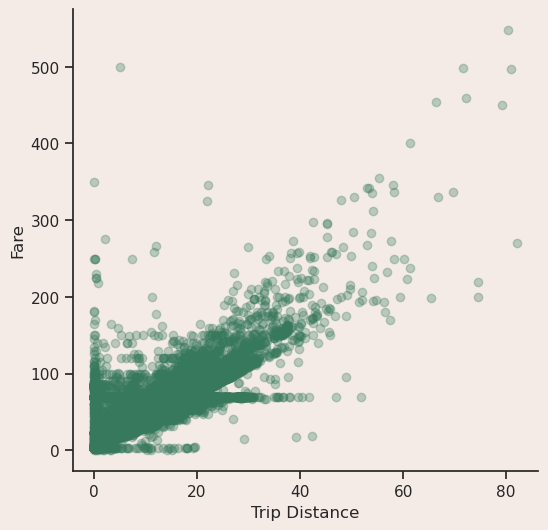

In [15]:
fig,ax = plt.subplots(1,1, figsize=(6,6))
ax.scatter(df.trip_distance, df.fare_amount, color=GREEN, alpha=0.3)
ax.set_xlabel("Trip Distance")
ax.set_ylabel("Fare");

In [16]:
# plotly pairwise plot of all the variables raw and then after they have been feature engineered
import plotly.express as px

_df = df.filter(items=['trip_distance', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'fare_amount', 'total_amount', 'tip_amount', 'congestion_surcharge', 'airport_fee', 'tolls_amount', 'payment_type', 'mta_tax'])
fig = px.scatter_matrix(_df)

fig.show()

ModuleNotFoundError: No module named 'plotly'

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScalar

def transform_features(self, df):
    obviously_bad_data_filters = [

    df.fare_amount > 0,         # fare_amount in US Dollars
    df.trip_distance <= 100,    # trip_distance in miles
    df.trip_distance > 0,

    # done: add some logic to filter out what you decide is bad data!
    # TIP: Don't spend too much time on this step for this project though, it practice it is a never-ending process.
    df.passenger_count > 0,
    ~df.trip_distance.isnull()
    ]

    for f in obviously_bad_data_filters:
        _df = df[f]

    # done: 
        # Try to complete tasks 2 and 3 with this function doing nothing like it currently is.
        # Understand what is happening.
        # Revisit task 1 and think about what might go in this function.
    
    # shortlist the features worth engineering
    _df = df.filter(items=['trip_distance', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'fare_amount', 'total_amount', 'tip_amount', 'congestion_surcharge', 'airport_fee', 'tolls_amount', 'payment_type', 'mta_tax'])
    
    # Numerical features
    numerical_cols_X = _df.select_dtypes(include=['int64', 'float64']).columns
    num_pipeline = Pipeline([
        ('scalar', MinMaxScalar())
    ])
    # categorical features

    # boolean features
    return df

## Task 2: Write a flow

In this task, you will deploy a workflow to Argo Workflows. The following flow is mostly written for you, minus a few TODO items.

Notice the use of the `@trigger` flow-level decorator.
In this flow, this is telling Argo to listen for events named `s3`, and to trigger a run of the flow when the S3 event is emitted. 
The S3 event your sandbox is listening for are the updates to the `latest.parquet` file mentioned in the comments in [Task 1](#task-1-eda). 

In [10]:
%%writefile ../flows/cloud/event_triggered_linear_regression.py
from metaflow import FlowSpec, step, card, conda_base, current, Parameter, Flow, trigger
from metaflow.cards import Markdown, Table, Image, Artifact

URL = "https://outerbounds-datasets.s3.us-west-2.amazonaws.com/taxi/latest.parquet"
DATETIME_FORMAT = '%Y-%m-%d %H:%M:%S'

@trigger(events=['s3'])
@conda_base(libraries={'pandas': '1.4.2', 'pyarrow': '11.0.0', 'numpy': '1.21.2', 'scikit-learn': '1.1.2', 'plotly': '5.3.1'})
class TaxiFarePrediction(FlowSpec):

    data_url = Parameter("data_url", default=URL)

    def transform_features(self, df):

        # TODO: 
            # Try to complete tasks 2 and 3 with this function doing nothing like it currently is.
            # Understand what is happening.
            # Revisit task 1 and think about what might go in this function.
        from sklearn.pipeline import Pipeline
        from sklearn.compose import make_column_transformer
        from sklearn.preprocessing import OneHotEncoder
        from sklearn.preprocessing import MinMaxScalar
        
        # shortlist the features worth engineering
        _df = df.filter(items=['trip_distance', 'tpep_pickup_datetime', 'tpep_dropoff_datetime', 'passenger_count', 'fare_amount', 'total_amount', 'tip_amount', 'congestion_surcharge', 'airport_fee', 'tolls_amount', 'payment_type', 'mta_tax'])
        
        # Numerical features
        
        # categorical features

        # boolean features
        return df
    
    @catch(var="missing_data")
    @retry(times=2)
    @timeout(seconds=59)
    @step
    def start(self):

        import pandas as pd
        from sklearn.model_selection import train_test_split

        self.df = self.transform_features(pd.read_parquet(self.data_url))

        # NOTE: we are split into training and validation set in the validation step which uses cross_val_score.
        # This is a simple/naive way to do this, and is meant to keep this example simple, to focus learning on deploying Metaflow flows.
        
        # Tranform features here
        
        
        # Proper train val test split here, how does it differ for time series data? (research)
        # --> In practice, you want split time series data in more sophisticated ways and run backtests. 
        
        self.X = self.df["trip_distance"].values.reshape(-1, 1)
        self.y = self.df["total_amount"].values
        self.next(self.linear_model)

    @step
    def linear_model(self):
        "Fit a single variable, linear model to the data."
        from sklearn.linear_model import LinearRegression

        # TODO: Play around with the model if you are feeling it.
        self.model = LinearRegression()

        self.next(self.validate)

    def gather_sibling_flow_run_results(self):

        # storage to populate and feed to a Table in a Metaflow card
        rows = []

        # loop through runs of this flow 
        for run in Flow(self.__class__.__name__):
            if run.id != current.run_id:
                if run.successful:
                    icon = "✅" 
                    msg = "OK"
                    score = str(run.data.scores.mean())
                else:
                    icon = "❌"
                    msg = "Error"
                    score = "NA"
                    for step in run:
                        for task in step:
                            if not task.successful:
                                msg = task.stderr
                row = [Markdown(icon), Artifact(run.id), Artifact(run.created_at.strftime(DATETIME_FORMAT)), Artifact(score), Markdown(msg)]
                rows.append(row)
            else:
                rows.append([Markdown("✅"), Artifact(run.id), Artifact(run.created_at.strftime(DATETIME_FORMAT)), Artifact(str(self.scores.mean())), Markdown("This run...")])
        return rows
                
    
    @card(type="corise")
    @step
    def validate(self):
        from sklearn.model_selection import cross_val_score
        self.scores = cross_val_score(self.model, self.X, self.y, cv=5)
        current.card.append(Markdown("# Taxi Fare Prediction Results"))
        current.card.append(Table(self.gather_sibling_flow_run_results(), headers=["Pass/fail", "Run ID", "Created At", "R^2 score", "Stderr"]))
        self.next(self.end)

    @step
    def end(self):
        print("Success!")


if __name__ == "__main__":
    TaxiFarePrediction()

Overwriting ../flows/cloud/event_triggered_linear_regression.py


### Run the Flow

In [11]:
! python ../flows/cloud/event_triggered_linear_regression.py --environment=conda run

Metaflow 2.8.6+ob(v1) executing TaxiFarePrediction for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Bootstrapping conda environment...(this could take a few minutes)
2023-05-11 11:25:46.964 Workflow starting (run-id 14), see it in the UI at https://ui-pw-292508594.outerbounds.dev/TaxiFarePrediction/14
2023-05-11 11:25:47.846 [14/start/77 (pid 18737)] Task is starting.
2023-05-11 11:25:52.017 [14/start/77 (pid 18737)] Task finished successfully.
2023-05-11 11:25:52.983 [14/linear_model/78 (pid 18834)] Task is starting.
2023-05-11 11:25:55.512 [14/linear_model/78 (pid 18834)] Task finished successfully.
2023-05-11 11:25:56.479 [14/validate/79 (pid 18887)] Task is starting.
2023-05-11 11:26:01.035 [14/validate/79 (pid 18887)] Task finished successfully.
2023-05-11 11:26:01.971 [14/end/80 (pid 18954)] Task is starting.
2023-05-11 11:26:02.921 [14/end/80 (pid 18954)] Success!
2023-05-11 11:26:03.736 [14/end/80 (pid 18954)] Task finish

## Task 3: Promote to Production

Once the workflow in the previous section is running and logging results as you like, it is time to deploy this workflow to production, so it can run in the cloud without manually triggering it. 

You can read more in [Metaflow's Argo documentation](https://docs.metaflow.org/production/scheduling-metaflow-flows/scheduling-with-argo-workflows).

### Deploying the workflow to Argo

In [12]:
# NOTE: If you run from this from the terminal you may need to adjust the path to the flow file, depending on where you saved it - what comes after %%writefile? 
! python ../flows/cloud/event_triggered_linear_regression.py --environment=conda --with retry argo-workflows create 

Metaflow 2.8.6+ob(v1) executing TaxiFarePrediction for user:sandbox
Validating your flow...
    The graph looks good!
Running pylint...
    Pylint is happy!
Deploying taxifareprediction to Argo Workflows...
It seems this is the first time you are deploying taxifareprediction to Argo Workflows.

A new production token generated.

The namespace of this production flow is
    production:taxifareprediction-0-ouyj
To analyze results of this production flow add this line in your notebooks:
    namespace("production:taxifareprediction-0-ouyj")
If you want to authorize other people to deploy new versions of this flow to Argo Workflows, they need to call
    argo-workflows create --authorize taxifareprediction-0-ouyj
when deploying this flow to Argo Workflows for the first time.
See "Organizing Results" at https://docs.metaflow.org/ for more information about production tokens.

Bootstrapping conda environment...(this could take a few minutes)
Workflow taxifareprediction for flow TaxiFarePredic

Now, go to the Argo deployment attached to your sandbox by finding your ID from the URL in your browser.

Your sandbox has a unique ID, visible in the URL with this pattern.
```
https://vs-<YOUR ID>.outerbounds.dev/<DELETE EVERYTHING AFTER THIS>
```

Remove the `vs` part in front, and everything after `.dev`, then navigate to your sandboxes Argo deployment at:
```
https://argo-<YOUR ID>.outerbounds.dev/
```

Navigating to the "Workflow Templates" section of the Argo UI, you should find your workflow has been deployed:

<img src="../img/argo-workflow-template.png" width="1200px">

### Manually trigger the workflow

In [ ]:
! python ../flows/cloud/event_triggered_linear_regression.py --environment=conda argo-workflows trigger

After triggering the worfklow, return to your Argo dashboard and navigate to the `Workflows` section to see your flow executing:

<img src="../img/argo-workflow.png" width="1200px">

### How is the flow "automatically" triggered? 

In the previous section, you manually triggered the deployed flow using a Metaflow command. 
So how will it run without that manual trigger in production? 

1. There is a script running in the background in your sandbox that looks at the `latest.parquet` file in S3 and emits an `S3` when it has changed since the last `TaxiFarePrediction` flow run was created. As mentioned earlier, the file is being updated every hour, time shifting the [NYC taxi data stream from January 2023](https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2023-01.parquet).
2. When the events are emitted, the same thing happens as the command you ran in [the previous section](#manually-trigger-the-workflow).

## Bonus Task 4: Handle Failures! 


If you deployed the flow in the previous task, excellent job! 
Now it is time to harden the workflow so it is robust to the vagaries of real world data.

Specifically, at some point we will intentionally corrupt some of the training data, to simulate a common real world occurence.

Can you,
1. Figure out what is happening in the new data that is causing an error?
2. Add a few lines of code to your `TaxiFarePrediction` flow's `start` step that will make your flow robust to this kind of data quality issue?
3. How would you refactor the `TaxiFarePrediction` to use the decorators you learned in this week's lesson, such as `@catch`, `@retry`, etc.? 

(Optional) TODO: Write a report of your findings to these questions.
(Optional) TODO: Update your production deployment of `TaxiFarePrediction` with the new approach(es).

### 1. What's causing the scheduled runs to fail?

1. Missing data / data hygeine issue with linear regression input (most of the failed runs indicate this)

'''LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values'''

2. something else? prolly not.

### 2. Solve: Added lines of code in the start step trying to address missing/Nan data issue. Also adding train-validation-test split

### 3. Catch issues: Added @catch (a hail mary) at the top of the flow. Added @retry at the start step with a timeout of a few tries to catch any issue model promotion step.
